In [1]:
import os
#import utils
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# To set the backend of matplotlib to the 'inline' backend
#%matplotlib inline

from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
MIXED_PRECISION = True
XLA_ACCELERATE  = False 

GPUS = tf.config.experimental.list_physical_devices('GPU')
if GPUS:
    try:
        for GPU in GPUS:
            tf.config.experimental.set_memory_growth(GPU, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(GPUS), "Physical GPUs,", len(logical_gpus), "Logical GPUs") 
    except RuntimeError as  RE:
        print(RE)

if MIXED_PRECISION:
    policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    tf.keras.mixed_precision.experimental.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')
    
strategy = tf.distribute.get_strategy()
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}') 
print("Tensorflow version " + tf.__version__)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r '/content/drive/MyDrive/archive.zip' '/content'

In [4]:
!unzip archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

### Data Sets
- Number of Images in Training and Testing Datasets


In [5]:

print("Images in Training Data")
print("_______________________")
for expression in os.listdir("/content/train/"):
    print(str(len(os.listdir("/content/train/" + expression))) + " " + expression + " images")

print("\n")

print("Images in Testing Data")
print("_______________________")
for expression in os.listdir("/content/test/"):
    print(str(len(os.listdir("/content/test/" + expression))) + " " + expression + " images")
    


Images in Training Data
_______________________
4097 fear images
7215 happy images
4965 neutral images
436 disgust images
3171 surprise images
4830 sad images
3995 angry images


Images in Testing Data
_______________________
1024 fear images
1774 happy images
1233 neutral images
111 disgust images
831 surprise images
1247 sad images
958 angry images


### Create Training and Validation Batches
- ImageDataGenerators to create Training and Validation Batches by loading images from corresponding directories

In [6]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory("/content/train/",
                                                    target_size=(img_size,img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory("/content/test/",
                                                    target_size=(img_size,img_size),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Convolutional Nueral Network (CNN) Model
- A Nueral Network using 4 Convolutional Layers and 2 Fully Connected dense Layers.


In [ ]:
# Initialising the CNN
model = Sequential()

# 1st Convolution Layer

# There are 64 (3,3) filters with "same" Padding and Shape of the Input_Image is (48,48,3)
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,3)))

# Normalizing to speed up learning.
model.add(BatchNormalization())

# Applying Non Linear Activation Function "relu"
model.add(Activation('relu'))  

# Adding a Max Pool Layer of size (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layer with 0.25 fraction of the input units to drop
model.add(Dropout(0.25))




# 2nd Convolution layer

# There are 128 (5,5) filters with "same" Padding 
model.add(Conv2D(128,(5,5), padding='same'))

# Normalizing to speed up learning.
model.add(BatchNormalization())

# Applying Non Linear Activation Function "relu"
model.add(Activation('relu'))

# Adding a Max Pool Layer of size (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layer with 0.25 fraction of the input units to drop
model.add(Dropout(0.25))




# 3rd Convolution layer

# There are 512 (3,3) filters with "same" Padding 

model.add(Conv2D(512,(3,3), padding='same'))

# Normalizing to speed up learning.
model.add(BatchNormalization())

# Applying Non Linear Activation Function "relu"
model.add(Activation('relu'))

# Adding a Max Pool Layer of size (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layer with 0.25 fraction of the input units to drop
model.add(Dropout(0.25))





# 4th Convolution layer

# There are 512 (3,3) filters with "same" Padding 
model.add(Conv2D(512,(3,3), padding='same'))

# Normalizing to speed up learning.
model.add(BatchNormalization())

# Applying Non Linear Activation Function "relu"
model.add(Activation('relu'))

# Adding a Max Pool Layer of size (2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layer with 0.25 fraction of the input units to drop 
model.add(Dropout(0.25))



# Flattening
model.add(Flatten())


# Fully connected layer with 256 nuerons
model.add(Dense(256))

# Normalizing to speed up learning.
model.add(BatchNormalization())

# Applying Non Linear Activation Function "relu"
model.add(Activation('relu'))

# Dropout layer with 0.25 fraction of the input units to drop
model.add(Dropout(0.25))



# Fully connected layer with 512 nuerons
model.add(Dense(512))

# Normalizing to speed up learning.
model.add(BatchNormalization())

# Applying Non Linear Activation Function "relu"
model.add(Activation('relu'))

# Dropout layer with 0.25 fraction of the input units to drop
model.add(Dropout(0.25))

# Adding a final Dense Layer with 7 outputs corresponding to 7 different emotions with a "softmax" Activation Function 
model.add(Dense(7, activation='softmax'))

### Compiling the Model
- Adam Optimizer :- Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data

In [ ]:
opt = Adam(learning_rate=0.0005)

# Compile defines the loss function, the optimizer and the metrics.

# As we have Categorical Values we will use 'categorical_crossentropy' loss function
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Let us check the details of the Model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_6 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)      

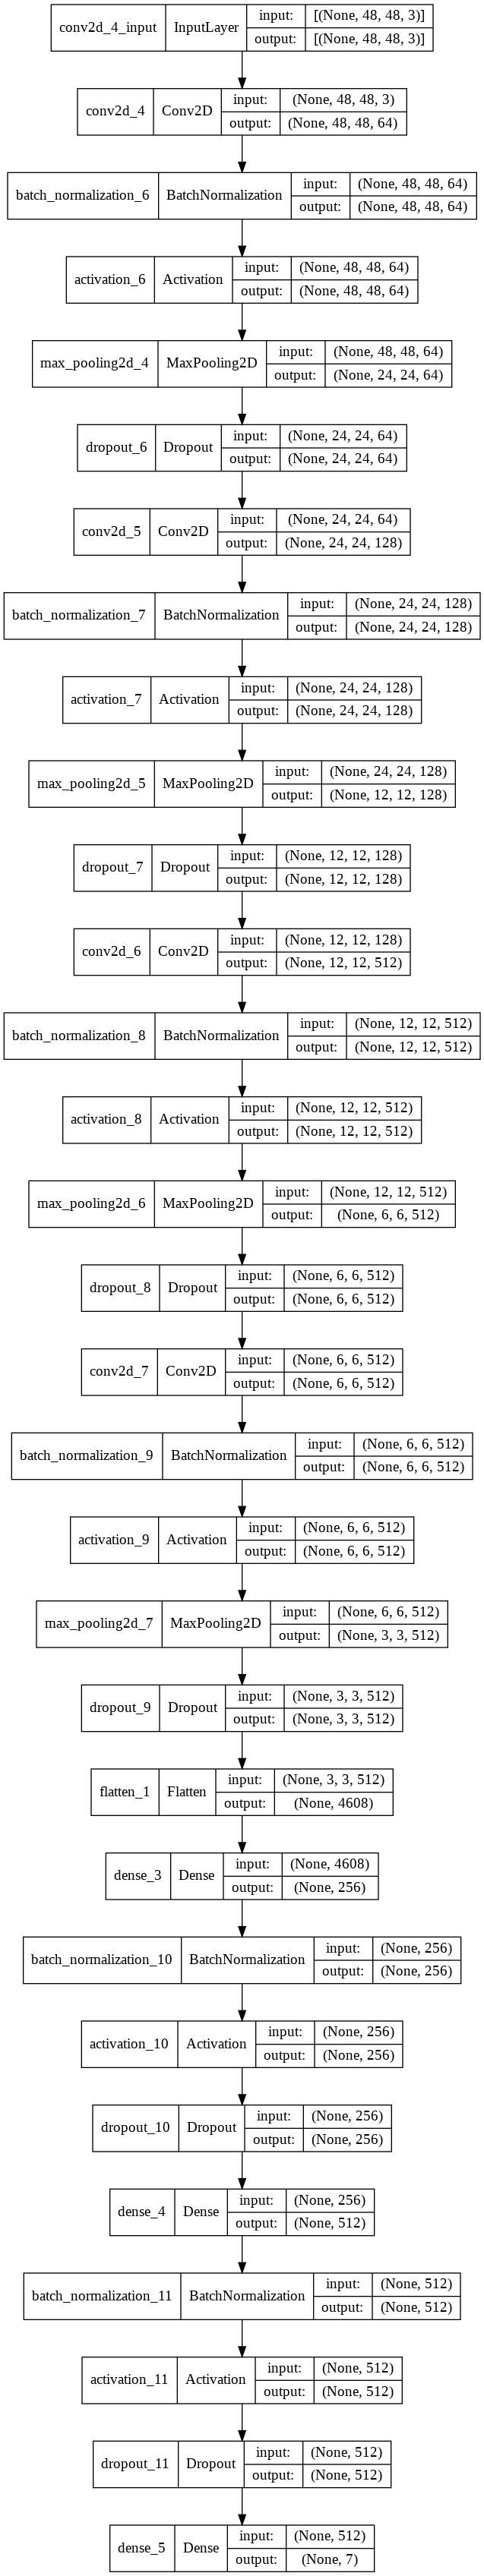

In [ ]:
plot_model(model, to_file='model_1.png', show_shapes=True, show_layer_names=True)

### Train and Evaluate Model

In [ ]:
# Let us train the Model 15 times
epochs = 60

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Create a Callback which reduces the Learning rate by a factor of "0.1" when the val_loss does not decrease
# after 2 epochs also and allowing the minimum value of Learning Rate to be 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')


# Create another Callback which saves the Model Weights by monitoring the Val_Accuracy
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)


# A callback is an object that can perform actions at various stages of training
# (e.g. at the start or end of an epoch, before or after a single batch, etc).
callbacks = [checkpoint, reduce_lr]

# Fitting the model .
history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 1.7966 - accuracy: 0.3097
Epoch 00001: saving model to model_weights.h5
448/448 [==============================] - 33s 66ms/step - loss: 1.7966 - accuracy: 0.3097 - val_loss: 1.5112 - val_accuracy: 0.4247 - lr: 5.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 1.4769 - accuracy: 0.4337
Epoch 00002: saving model to model_weights.h5
448/448 [==============================] - 31s 69ms/step - loss: 1.4769 - accuracy: 0.4337 - val_loss: 1.4839 - val_accuracy: 0.4348 - lr: 5.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 1.3332 - accuracy: 0.4871
Epoch 00003: saving model to model_weights.h5
448/448 [==============================] - 31s 70ms/step - loss: 1.3332 - accuracy: 0.4871 - val_loss: 1.3659 - val_accuracy: 0.4583 - lr: 5.0000e-04
Epoch 4/60
448/448 [==============================] - ETA: 0s - loss: 1.2496 - accuracy: 0.5232
Epoch 00004: saving model to

### Represent Model as JSON String

In [ ]:
# Converting the model into JSON format and storing it in "fer_model.json" file. 
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
#Confusion Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator,validation_generator.n//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['fear' ,'surprise' ,'neutral',  'happy' , 'angry'  ,'disgust'  , 'sad']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[ 509   18   88   48  115  156   24]
 [  25   60    4    3    5   12    2]
 [  92    9  387   42  128  246  120]
 [  23    1   23 1530  100   61   36]
 [  56    3   43   81  844  186   20]
 [ 106    2   88   66  248  720   17]
 [  19    1   49   39   22   16  685]]
Classification Report
              precision    recall  f1-score   support

        fear       0.61      0.53      0.57       958
    surprise       0.64      0.54      0.59       111
     neutral       0.57      0.38      0.45      1024
       happy       0.85      0.86      0.85      1774
       angry       0.58      0.68      0.63      1233
     disgust       0.52      0.58      0.54      1247
         sad       0.76      0.82      0.79       831

    accuracy                           0.66      7178
   macro avg       0.65      0.63      0.63      7178
weighted avg       0.66      0.66      0.65      7178



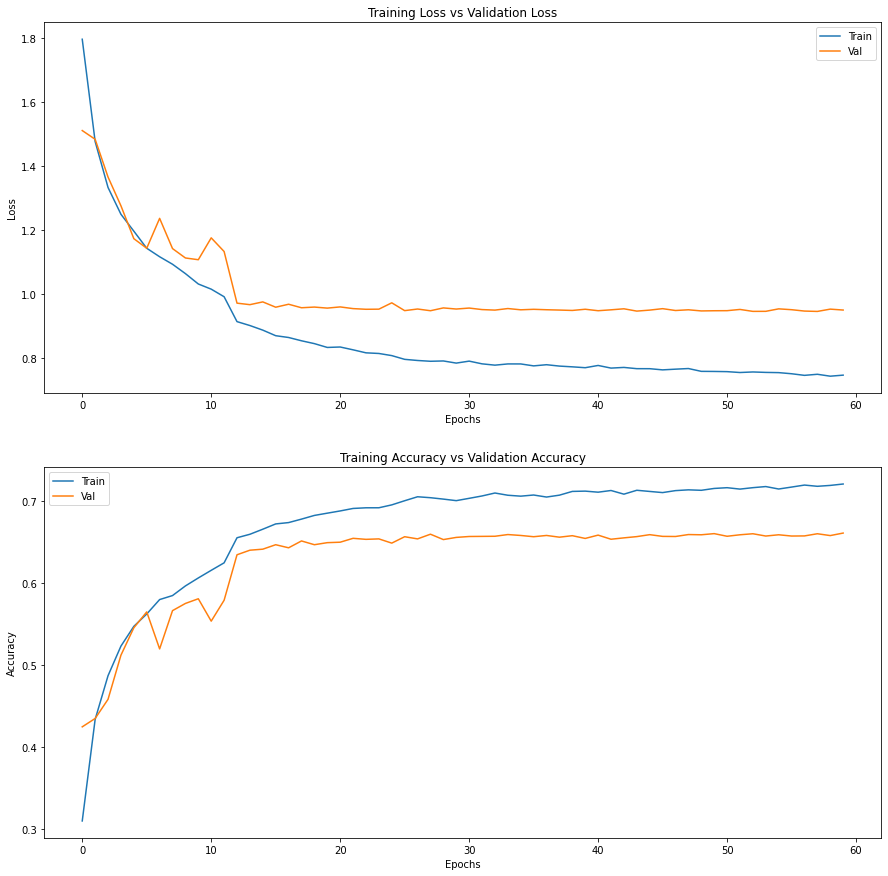

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

### ModeL 2


In [7]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [8]:
model_2 = get_model((48,48,3))
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


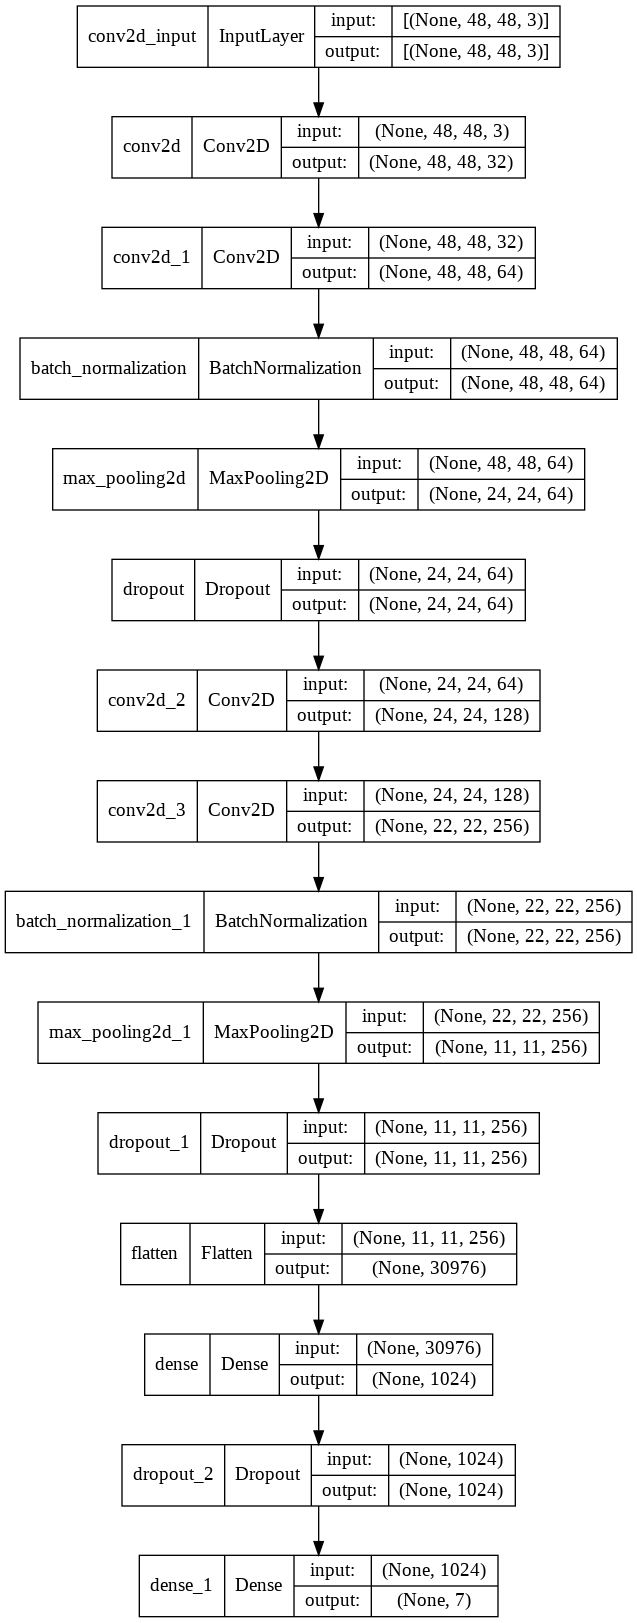

In [9]:
plot_model(model_2, to_file='model_2.png', show_shapes=True, show_layer_names=True)

In [10]:
chk_path_2 = 'model_2.h5'

# Let us train the Model 15 times
epochs = 60

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint(filepath=chk_path_2,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback_2 = tf.keras.callbacks.TensorBoard( histogram_freq=1)
csv_logger_2 = CSVLogger('training.log')

callback_2 = [checkpoint, reduce_lr, csv_logger_2]

In [11]:
model_2_history = model_2.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=60,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callback_2
)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.3209 - accuracy: 0.3134
Epoch 00001: val_loss improved from inf to 3.76394, saving model to model_2.h5
448/448 [==============================] - 45s 79ms/step - loss: 4.3209 - accuracy: 0.3134 - val_loss: 3.7639 - val_accuracy: 0.3916 - lr: 1.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.5478 - accuracy: 0.3868
Epoch 00002: val_loss improved from 3.76394 to 3.21515, saving model to model_2.h5
448/448 [==============================] - 35s 78ms/step - loss: 3.5478 - accuracy: 0.3868 - val_loss: 3.2152 - val_accuracy: 0.4467 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 3.0134 - accuracy: 0.4300
Epoch 00003: val_loss improved from 3.21515 to 2.87245, saving model to model_2.h5
448/448 [==============================] - 35s 79ms/step - loss: 3.0134 - accuracy: 0.4300 - val_loss: 2.8724 - val_accuracy: 0.4508 - lr: 1.0000e-04
Epoch 4/60
448/44

In [12]:
#Confusion Matrix and Classification Report
Y_pred = model_2.predict_generator(validation_generator,validation_generator.n//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['fear' ,'surprise' ,'neutral',  'happy' , 'angry'  ,'disgust'  , 'sad']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[ 531    3   87   73   95  150   19]
 [  31   59    7    1    3    9    1]
 [ 114    2  460   49  119  207   73]
 [  55    0   28 1505   92   63   31]
 [  95    2   64   99  743  215   15]
 [ 148    0  131   82  195  672   19]
 [  22    4   66   40   25   29  645]]
Classification Report
              precision    recall  f1-score   support

        fear       0.53      0.55      0.54       958
    surprise       0.84      0.53      0.65       111
     neutral       0.55      0.45      0.49      1024
       happy       0.81      0.85      0.83      1774
       angry       0.58      0.60      0.59      1233
     disgust       0.50      0.54      0.52      1247
         sad       0.80      0.78      0.79       831

    accuracy                           0.64      7178
   macro avg       0.66      0.61      0.63      7178
weighted avg       0.64      0.64      0.64      7178



### Loss and Accuracy plot

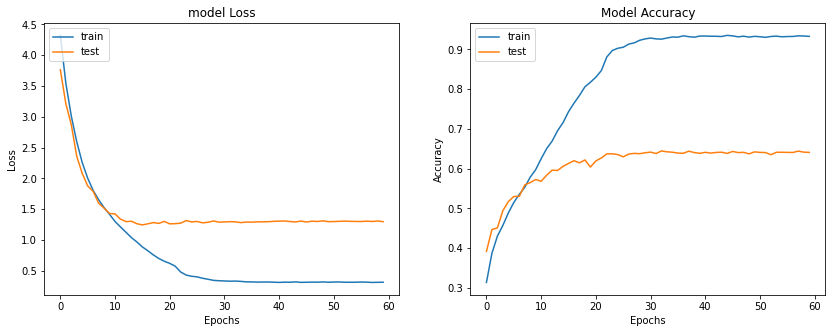

In [32]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(model_2_history.history['accuracy'])
plt.plot(model_2_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(model_2_history.history['loss'])
plt.plot(model_2_history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Model 3

In [25]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [27]:
model_3 = get_model((48,48,3))
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)      

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [28]:
chk_path = 'model_3.h5'

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard( histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [29]:
model_3_history = model_3.fit(x=train_generator,
                 validation_data=validation_generator,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 12.2337 - accuracy: 0.2812
Epoch 00001: val_loss improved from inf to 10.88117, saving model to model_3.h5
448/448 [==============================] - 54s 114ms/step - loss: 12.2337 - accuracy: 0.2812 - val_loss: 10.8812 - val_accuracy: 0.3636 - lr: 1.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 9.5630 - accuracy: 0.3705
Epoch 00002: val_loss improved from 10.88117 to 8.33930, saving model to model_3.h5
448/448 [==============================] - 50s 111ms/step - loss: 9.5630 - accuracy: 0.3705 - val_loss: 8.3393 - val_accuracy: 0.4234 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 7.2177 - accuracy: 0.4179
Epoch 00003: val_loss improved from 8.33930 to 6.16496, saving model to model_3.h5
448/448 [==============================] - 50s 111ms/step - loss: 7.2177 - accuracy: 0.4179 - val_loss: 6.1650 - val_accuracy: 0.4573 - lr: 1.0000e-04
Epoch 4/6

In [30]:
#Confusion Matrix and Classification Report
Y_pred = model_3.predict_generator(validation_generator,validation_generator.n//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['fear' ,'surprise' ,'neutral',  'happy' , 'angry'  ,'disgust'  , 'sad']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[ 584   12  100   34   84  125   19]
 [  23   71    3    2    1    9    2]
 [ 117    4  494   25  108  189   87]
 [  33    0   27 1545   86   52   31]
 [  78    2   59   73  819  184   18]
 [ 139    0  126   47  204  712   19]
 [  19    2   62   35   21   22  670]]
Classification Report
              precision    recall  f1-score   support

        fear       0.59      0.61      0.60       958
    surprise       0.78      0.64      0.70       111
     neutral       0.57      0.48      0.52      1024
       happy       0.88      0.87      0.87      1774
       angry       0.62      0.66      0.64      1233
     disgust       0.55      0.57      0.56      1247
         sad       0.79      0.81      0.80       831

    accuracy                           0.68      7178
   macro avg       0.68      0.66      0.67      7178
weighted avg       0.68      0.68      0.68      7178



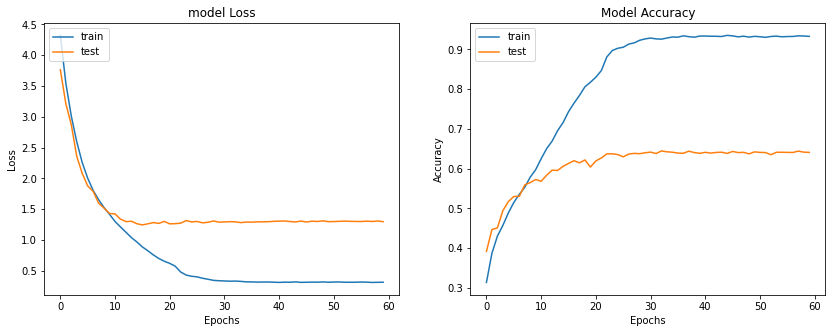

In [31]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(model_2_history.history['accuracy'])
plt.plot(model_2_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(model_2_history.history['loss'])
plt.plot(model_2_history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Resnet152 Model

In [ ]:
base_model = tf.keras.applications.ResNet152(weights=None, include_top = False, input_shape = (48,48,1))
for layer in base_model.layers:
  layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(1000, activation='relu')(x)
predictions = Dense(7, activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
opt = Adam(learning_rate=0.0005)
head_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])



head_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 54, 54, 1)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 24, 24, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 24, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [ ]:
# Let us train the Model 15 times
epochs = 60

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Create a Callback which reduces the Learning rate by a factor of "0.1" when the val_loss does not decrease
# after 2 epochs also and allowing the minimum value of Learning Rate to be 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')


# Create another Callback which saves the Model Weights by monitoring the Val_Accuracy
checkpoint = ModelCheckpoint("model_weights_resnet.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)


# A callback is an object that can perform actions at various stages of training
# (e.g. at the start or end of an epoch, before or after a single batch, etc).
callbacks = [checkpoint, reduce_lr]

# Fitting the model .
history = head_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 10.3605 - accuracy: 0.1993
Epoch 00001: saving model to model_weights_resnet.h5
448/448 [==============================] - 94s 184ms/step - loss: 10.3605 - accuracy: 0.1993 - val_loss: 3.1420 - val_accuracy: 0.2573 - lr: 5.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 2.1512 - accuracy: 0.2296
Epoch 00002: saving model to model_weights_resnet.h5
448/448 [==============================] - 85s 190ms/step - loss: 2.1512 - accuracy: 0.2296 - val_loss: 1.8372 - val_accuracy: 0.2206 - lr: 5.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 1.9485 - accuracy: 0.2494
Epoch 00003: saving model to model_weights_resnet.h5
448/448 [==============================] - 79s 176ms/step - loss: 1.9485 - accuracy: 0.2494 - val_loss: 1.9521 - val_accuracy: 0.2610 - lr: 5.0000e-04
Epoch 4/60
448/448 [==============================] - ETA: 0s - loss: 1.8306 - accuracy: 0.2511
Ep

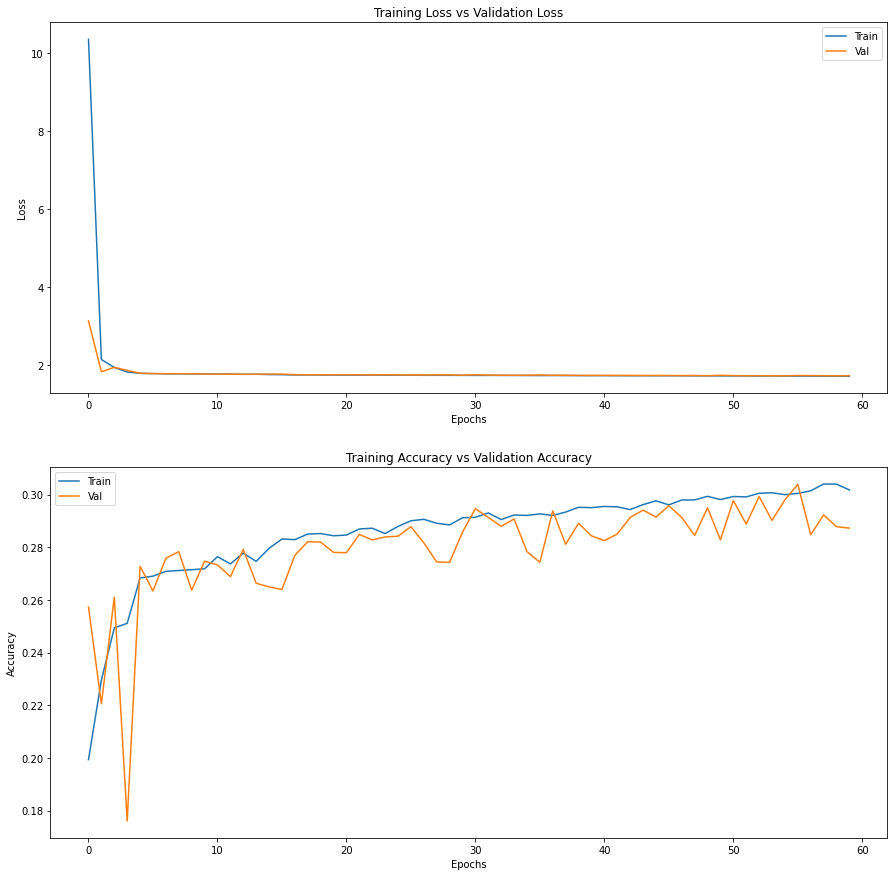

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

### VGG-16 Model


In [ ]:
base_model = tf.keras.applications.VGG16(weights=None, include_top = False, input_shape = (48,48,1))
for layer in base_model.layers:
  layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(1000, activation='relu')(x)
predictions = Dense(7, activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
opt = Adam(learning_rate=0.0005)
head_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])



head_model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
# Let us train the Model 15 times
epochs = 60
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Create a Callback which reduces the Learning rate by a factor of "0.1" when the val_loss does not decrease
# after 2 epochs also and allowing the minimum value of Learning Rate to be 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')


# Create another Callback which saves the Model Weights by monitoring the Val_Accuracy
checkpoint = ModelCheckpoint("model_weights_cnn.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)


# A callback is an object that can perform actions at various stages of training
# (e.g. at the start or end of an epoch, before or after a single batch, etc).
callbacks = [checkpoint, reduce_lr]

# Fitting the model .
history = head_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 1.8081 - accuracy: 0.2453
Epoch 00001: saving model to model_weights_cnn.h5
448/448 [==============================] - 27s 57ms/step - loss: 1.8081 - accuracy: 0.2453 - val_loss: 1.7912 - val_accuracy: 0.2750 - lr: 5.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 1.7754 - accuracy: 0.2731
Epoch 00002: saving model to model_weights_cnn.h5
448/448 [==============================] - 24s 54ms/step - loss: 1.7754 - accuracy: 0.2731 - val_loss: 1.7527 - val_accuracy: 0.2984 - lr: 5.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 1.7565 - accuracy: 0.2816
Epoch 00003: saving model to model_weights_cnn.h5
448/448 [==============================] - 24s 55ms/step - loss: 1.7565 - accuracy: 0.2816 - val_loss: 1.7395 - val_accuracy: 0.3133 - lr: 5.0000e-04
Epoch 4/60
448/448 [==============================] - ETA: 0s - loss: 1.7383 - accuracy: 0.2948
Epoch 00004: sav

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

### VGG-16 last layer not freezed

In [ ]:
base_model = tf.keras.applications.VGG16(weights=None, include_top = False, input_shape = (48,48,1))
for layer in base_model.layers:
  if layer.name == 'block5_conv1':
    break
  layer.trainable = False

last = base_model.layers[-1].output
x = Flatten()(base_model.output)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(7, activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
opt = Adam(learning_rate=0.0001)
head_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])



head_model.summary()

In [ ]:
# Let us train the Model 15 times
epochs = 60
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Create a Callback which reduces the Learning rate by a factor of "0.1" when the val_loss does not decrease
# after 2 epochs also and allowing the minimum value of Learning Rate to be 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')


# Create another Callback which saves the Model Weights by monitoring the Val_Accuracy
checkpoint = ModelCheckpoint("model_weights_cnn.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)


# A callback is an object that can perform actions at various stages of training
# (e.g. at the start or end of an epoch, before or after a single batch, etc).
callbacks = [checkpoint, reduce_lr]

# Fitting the model .
history = head_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

### Transfer Learning VGG16 with color channels ( Our Best Performing Model)


In [13]:
base_model_3 = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

model=Sequential()
model.add(base_model_3)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))
# Model Summary
for layer in base_model_3.layers:
    layer.trainable=False
model.summary()



58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 4096)              2101248   
                                                                 
 dropout_4 (Dropout)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              4195328   
                                                       

In [22]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
history=model.fit(x=train_generator,validation_data=validation_generator,epochs = 60,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/60
449/449 [==============================] - 26s 56ms/step - loss: 1.7712 - accuracy: 0.2748 - val_loss: 1.7005 - val_accuracy: 0.2955 - lr: 0.0010
Epoch 2/60
449/449 [==============================] - 25s 55ms/step - loss: 1.7650 - accuracy: 0.2756 - val_loss: 1.7009 - val_accuracy: 0.2966 - lr: 0.0010
Epoch 3/60
449/449 [==============================] - 25s 55ms/step - loss: 1.7691 - accuracy: 0.2740 - val_loss: 1.7236 - val_accuracy: 0.2855 - lr: 0.0010
Epoch 4/60
449/449 [==============================] - 25s 55ms/step - loss: 1.7649 - accuracy: 0.2736 - val_loss: 1.7287 - val_accuracy: 0.2824 - lr: 0.0010
Epoch 5/60
449/449 [==============================] - 25s 56ms/step - loss: 1.7671 - accuracy: 0.2736 - val_loss: 1.7202 - val_accuracy: 0.2920 - lr: 0.0010
Epoch 6/60
449/449 [==============================] - 25s 55ms/step - loss: 1.7705 - accuracy: 0.2731 - val_loss: 1.7412 - val_accuracy: 0.2784 - lr: 0.0010
Epoch 7/60
449/449 [==============================] - 25s 

In [23]:
#Confusion Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator,validation_generator.n//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['fear' ,'surprise' ,'neutral',  'happy' , 'angry'  ,'disgust'  , 'sad']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


Confusion Matrix
[[   0    0   13  934    0    0   11]
 [   0    0    2  109    0    0    0]
 [   0    0   76  911    0    0   37]
 [   0    0   24 1743    0    0    7]
 [   0    0   22 1206    0    0    5]
 [   0    0   15 1228    0    0    4]
 [   0    0  129  459    0    0  243]]
Classification Report
              precision    recall  f1-score   support

        fear       0.00      0.00      0.00       958
    surprise       0.00      0.00      0.00       111
     neutral       0.27      0.07      0.12      1024
       happy       0.26      0.98      0.42      1774
       angry       0.00      0.00      0.00      1233
     disgust       0.00      0.00      0.00      1247
         sad       0.79      0.29      0.43       831

    accuracy                           0.29      7178
   macro avg       0.19      0.19      0.14      7178
weighted avg       0.20      0.29      0.17      7178



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


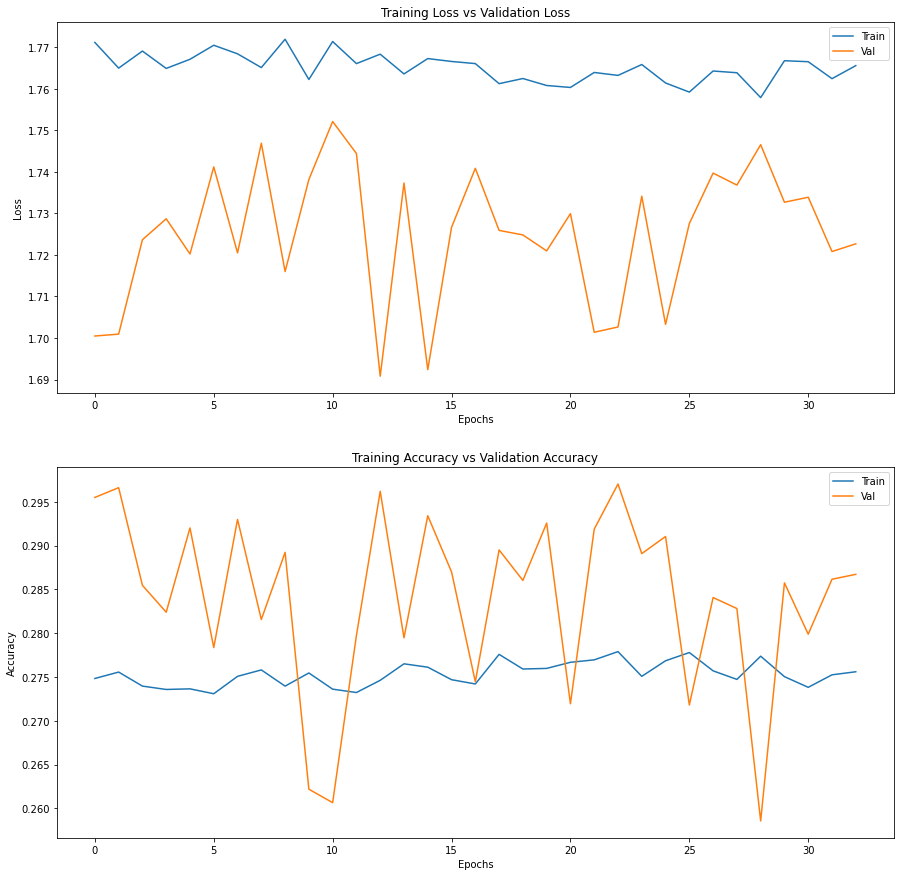

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])